In [1]:
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import folium
import shapely.wkb
from dotenv import load_dotenv

In [2]:

load_dotenv()

DB_USER = os.environ.get('DB_USER')
DB_PASSWORD = os.environ.get('DB_PASSWORD')
DB_HOST = os.environ.get('DB_HOST')
DB_PORT = os.environ.get('DB_PORT')
DB_NAME = os.environ.get('DB_NAME')

if not DB_PASSWORD: # Check for a key variable like password
    print("ERROR: Database credentials not loaded. Did you create a .env file and run load_dotenv()?")
    
else:
    print("Database credentials loaded successfully.")

# building a connection string
if all([DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME]):
    db_connection_str = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
    db_connection = create_engine(db_connection_str)

    print("SQLAlchemy engine created.")

    # Loading the view from the database
    sql = "SELECT * FROM v_tornadoes_with_county_data WHERE county_name IS NOT NULL;"
    try:
        gdf_joined = gpd.read_postgis(sql, db_connection, geom_col='tornado_start_location')
        print(gdf_joined.head())
    except Exception as e:
        print(f"Error executing query or reading data: {e}")
    finally:
        if 'db_connection' in locals():
            db_connection.dispose()
else:
    print("Cannot create database connection: one or more connection parameters are missing.")

Database credentials loaded successfully.
SQLAlchemy engine created.
   tornado_id  tornado_year  tornado_month tornado_state_abbr  \
0       58820          2014              7                 MA   
1       33953          1994              7                 NE   
2       62135          2017              6                 NE   
3       17331          1976              5                 NE   
4       62138          2017              6                 NE   

        tornado_start_location  tornado_losses  tornado_closs_losses  \
0   POINT (-71.02190 42.39800)             4.0                   0.0   
1  POINT (-103.75000 41.42000)             0.0                   0.0   
2  POINT (-103.97540 41.39690)             0.0                   0.0   
3  POINT (-103.98000 41.40000)             0.0                   0.0   
4  POINT (-103.64000 41.48690)         25000.0                   0.0   

  county_name county_fips state_fips  \
0     Suffolk         025         25   
1      Banner         007  

In [3]:
ttdf = gdf_joined

In [4]:
# --- !!! REPLACE 'county_wkb' with the actual name of your WKB column !!! ---
wkb_column_to_convert = 'counties'

print(f"Converting column '{wkb_column_to_convert}' from WKB hex strings to geometry objects...")

# Apply the conversion in-place using a lambda function
ttdf[wkb_column_to_convert] = ttdf[wkb_column_to_convert].apply(
    lambda hex_wkb: shapely.wkb.loads(bytes.fromhex(hex_wkb), hex=False) # Convert hex string to bytes, then load WKB
                  if hex_wkb and pd.notna(hex_wkb) else None # Handle missing/invalid values safely
)

print("Conversion finished.")

Converting column 'counties' from WKB hex strings to geometry objects...
Conversion finished.


In [5]:
ttdf.head()

,tornado_id,tornado_year,tornado_month,tornado_state_abbr,tornado_start_location,tornado_losses,tornado_closs_losses,county_name,county_fips,state_fips,counties
0,58820,2014,7,MA,POINT (-71.02190 42.39800),4.0,0.0,Suffolk,025,25,"POLYGON ((-71.191155 42.28305899906086, -71.15..."
1,33953,1994,7,NE,POINT (-103.75000 41.42000),0.0,0.0,Banner,007,31,"POLYGON ((-104.052825235239 41.69795385212685,..."
2,62135,2017,6,NE,POINT (-103.97540 41.39690),0.0,0.0,Banner,007,31,"POLYGON ((-104.052825235239 41.69795385212685,..."
3,17331,1976,5,NE,POINT (-103.98000 41.40000),0.0,0.0,Banner,007,31,"POLYGON ((-104.052825235239 41.69795385212685,..."
4,62138,2017,6,NE,POINT (-103.64000 41.48690),25000.0,0.0,Banner,007,31,"POLYGON ((-104.052825235239 41.69795385212685,..."


In [6]:
ttdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58225 entries, 0 to 58224
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   tornado_id              58225 non-null  int64   
 1   tornado_year            58225 non-null  int64   
 2   tornado_month           58225 non-null  int64   
 3   tornado_state_abbr      58225 non-null  object  
 4   tornado_start_location  58225 non-null  geometry
 5   tornado_losses          58225 non-null  float64 
 6   tornado_closs_losses    58225 non-null  float64 
 7   county_name             58225 non-null  object  
 8   county_fips             58225 non-null  object  
 9   state_fips              58225 non-null  object  
 10  counties                58225 non-null  object  
dtypes: float64(2), geometry(1), int64(3), object(5)
memory usage: 4.9+ MB


In [11]:
print(ttdf.crs)

epsg:4326


In [12]:
import folium
m = folium.Map(tiles="cartodbpositron")

In [15]:
ok2020 = ttdf.loc[(ttdf['tornado_state_abbr'] == 'OK') & (ttdf['tornado_year'] == 2020)]
ok2020 = ok2020.drop(columns= ['tornado_year', 'tornado_state_abbr']).reset_index()

In [17]:
ok2020.head()

,tornado_id,tornado_year,tornado_month,tornado_state_abbr,tornado_start_location,tornado_losses,tornado_closs_losses,county_name,county_fips,state_fips,counties
2053,65612,2020,4,OK,POINT (-98.09100 34.71100),50000.0,0.0,Comanche,031,40,"POLYGON ((-98.826008 34.594412999117786, -98.8..."
9363,65802,2020,5,OK,POINT (-94.57240 36.14230),0.0,0.0,Adair,001,40,"POLYGON ((-94.797279 36.16138999910084, -94.56..."
10372,65829,2020,5,OK,POINT (-97.19800 35.03400),20000.0,0.0,Cleveland,027,40,"POLYGON ((-97.671369 35.37715099910898, -97.42..."
13659,65774,2020,5,OK,POINT (-95.33100 35.00380),0.0,0.0,Latimer,077,40,"POLYGON ((-95.507658 35.02919699911281, -95.34..."
17348,65620,2020,4,OK,POINT (-96.50400 34.39000),100000.0,0.0,Johnston,069,40,"POLYGON ((-96.933457 34.33266099912087, -96.88..."


In [18]:
loss_per_county_ok2020 = ok2020.groupby('county_name')['tornado_losses'].sum().sort_values(ascending=False)
loss_per_county_ok2020.head()

county_name
McCurtain    800000.0
Marshall     520000.0
Muskogee     350000.0
Garvin       200000.0
Bryan        120000.0
Name: tornado_losses, dtype: float64

<Axes: xlabel='county_name'>

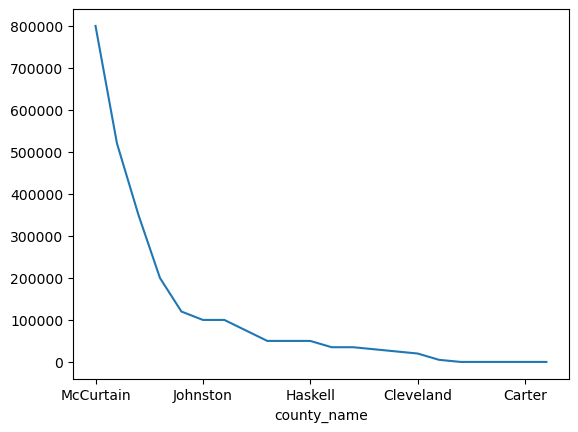

In [24]:
loss_per_county_ok2020.plot()

<Axes: >

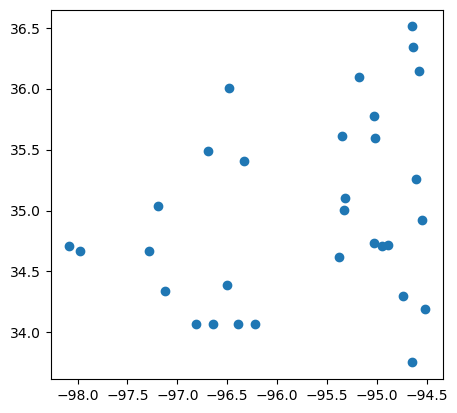

In [16]:
ok2020.geometry.plot()

<Axes: >

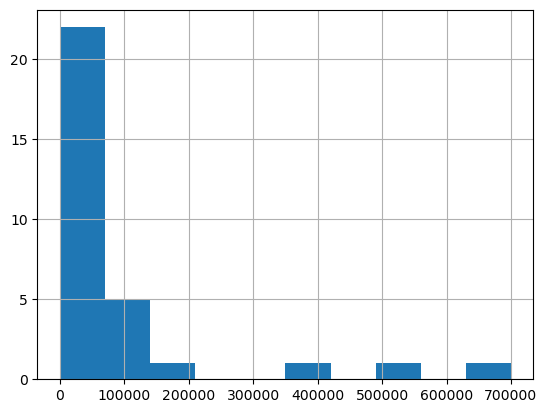

In [66]:
ok2020['tornado_losses'].hist()

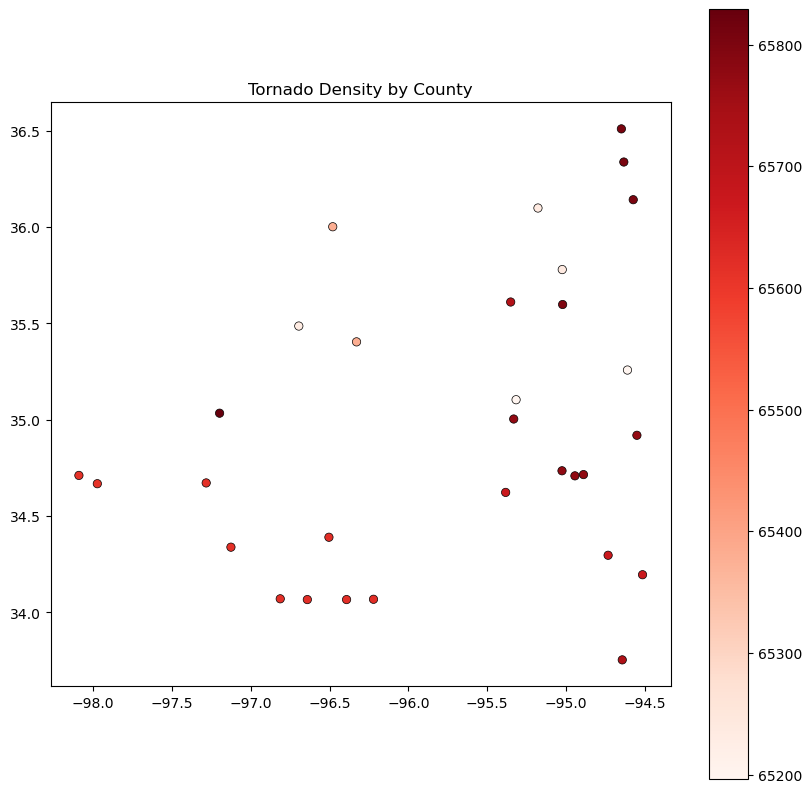

In [64]:
# Assuming gdf_counties has county polygons and a 'tornado_density' column
ok2020.plot(column='tornado_id', cmap='Reds', legend=True,
                 linewidth=0.5, edgecolor='black', figsize=(10, 10))
plt.title("Tornado Density by County")
plt.show()

In [36]:
ta_states = ['OK', 'TX', 'KS', 'NE']
years_to_filter = [2020, 2021, 2022,2023,2024,2025] # Example: Years 2010, 2015, 2020

tornado_alley = ttdf.loc[
    (ttdf['tornado_state_abbr'].isin(ta_states)) & \
    (ttdf['tornado_year'].isin(years_to_filter))
]

tornado_alley.reset_index().drop(columns='index')

,tornado_id,tornado_year,tornado_month,tornado_state_abbr,tornado_start_location,tornado_losses,tornado_closs_losses,county_name,county_fips,state_fips,counties
0,67031,2021,5,TX,POINT (-102.01610 36.30000),0.0,0.0,Sherman,421,48,"POLYGON ((-102.162463 36.500325999097534, -102..."
1,67032,2021,5,TX,POINT (-101.93270 36.29970),0.0,0.0,Sherman,421,48,"POLYGON ((-102.162463 36.500325999097534, -102..."
2,65415,2020,3,TX,POINT (-101.84990 36.17380),0.0,0.0,Sherman,421,48,"POLYGON ((-102.162463 36.500325999097534, -102..."
3,65982,2020,7,TX,POINT (-98.07230 29.29170),50000.0,0.0,Wilson,493,48,"POLYGON ((-98.407336 29.114434999197393, -98.1..."
4,66931,2021,5,TX,POINT (-101.88540 32.80570),0.0,0.0,Dawson,115,48,"POLYGON ((-102.20852 32.95895599913827, -102.0..."
...,...,...,...,...,...,...,...,...,...,...,...
558,66971,2021,5,KS,POINT (-101.46960 39.10110),0.0,0.0,Logan,109,20,"POLYGON ((-101.478195 39.13476099907614, -101...."
559,67874,2022,3,TX,POINT (-93.63360 31.14910),150000.0,0.0,Newton,351,48,"POLYGON ((-93.911126 31.158070999164085, -93.6..."
560,65210,2020,12,TX,POINT (-93.71490 30.63410),70000.0,0.0,Newton,351,48,"POLYGON ((-93.911126 31.158070999164085, -93.6..."
561,67258,2021,7,OK,POINT (-96.72000 36.08800),50000.0,0.0,Payne,119,40,"POLYGON ((-97.354132 36.15907199910087, -97.14..."


In [38]:
tornado_alley.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 563 entries, 25 to 58090
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   tornado_id              563 non-null    int64   
 1   tornado_year            563 non-null    int64   
 2   tornado_month           563 non-null    int64   
 3   tornado_state_abbr      563 non-null    object  
 4   tornado_start_location  563 non-null    geometry
 5   tornado_losses          563 non-null    float64 
 6   tornado_closs_losses    563 non-null    float64 
 7   county_name             563 non-null    object  
 8   county_fips             563 non-null    object  
 9   state_fips              563 non-null    object  
 10  counties                563 non-null    object  
dtypes: float64(2), geometry(1), int64(3), object(5)
memory usage: 52.8+ KB


In [40]:
ta_2020 = tornado_alley.loc[(tornado_alley['tornado_year'] == 2020)]

In [41]:
ta_2020_st = ta_2020.drop(column='

ta_2020.head()

,tornado_id,tornado_year,tornado_month,tornado_state_abbr,tornado_start_location,tornado_losses,tornado_closs_losses,county_name,county_fips,state_fips,counties
42,65415,2020,3,TX,POINT (-101.84990 36.17380),0.0,0.0,Sherman,421,48,"POLYGON ((-102.162463 36.500325999097534, -102..."
208,65982,2020,7,TX,POINT (-98.07230 29.29170),50000.0,0.0,Wilson,493,48,"POLYGON ((-98.407336 29.114434999197393, -98.1..."
1343,66079,2020,8,NE,POINT (-97.92150 40.58670),0.0,0.0,Clay,035,31,"POLYGON ((-98.278103 40.69829099906715, -97.82..."
1991,65447,2020,4,TX,POINT (-98.82480 30.30070),100000.0,0.0,Gillespie,171,48,"POLYGON ((-99.303996 30.499831999174354, -98.9..."
2053,65612,2020,4,OK,POINT (-98.09100 34.71100),50000.0,0.0,Comanche,031,40,"POLYGON ((-98.826008 34.594412999117786, -98.8..."


In [43]:
folium.GeoJson(ok2020, name="hello world").add_to(m)

folium.LayerControl().add_to(m)

m

TypeError: Object of type Polygon is not JSON serializable

In [11]:



sql = "SELECT * FROM v_tornadoes_with_county_data WHERE county_name IS NOT NULL;" # Example: only load tornadoes that matched a county

# Load data, specifying which column is the geometry for GeoPandas
# 'tornado_start_location' is the alias we gave to t.start_geom in the VIEW/SELECT
gdf_joined = gpd.read_postgis(sql, db_connection, geom_col='tornado_start_location')

print(gdf_joined.head())
print(f"Loaded {len(gdf_joined)} tornadoes with county information.")
# Now you can start your analysis and Folium mapping!

   tornado_id  tornado_year  tornado_month tornado_state_abbr  \
0       58820          2014              7                 MA   
1       33953          1994              7                 NE   
2       62135          2017              6                 NE   
3       17331          1976              5                 NE   
4       62138          2017              6                 NE   

        tornado_start_location  tornado_losses  tornado_closs_losses  \
0   POINT (-71.02190 42.39800)             4.0                   0.0   
1  POINT (-103.75000 41.42000)             0.0                   0.0   
2  POINT (-103.97540 41.39690)             0.0                   0.0   
3  POINT (-103.98000 41.40000)             0.0                   0.0   
4  POINT (-103.64000 41.48690)         25000.0                   0.0   

  county_name county_fips state_fips  
0     Suffolk         025         25  
1      Banner         007         31  
2      Banner         007         31  
3      Banner       